matching the unmasked imgs with  masked imgs

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
unmasked_path = "/Users/c.l.beothucus/Downloads/unmasked2/30000"
masked_path = "/Users/c.l.beothucus/Downloads/masked2/30000"
masked=[]
delete=[]
for i in os.listdir(masked_path):
    masked.append(i[:5])
for i in os.listdir(unmasked_path):
    if i[:5] not in masked:
        delete.append(i)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/c.l.beothucus/Downloads/masked2/30000'

In [ ]:
for i in delete:
    path = os.path.join(unmasked_path,i)
    try:
        os.remove(path)
    except Exception as e:
        print(path)

In [ ]:
delete

1. process imgs to size 224
2. MaskTheFace
3. ps black-white imgs
4. clean up black-white imgs to binary segmentation map

In [3]:
path="/Users/c.l.beothucus/Desktop/testing.jpg"
img = cv2.imread(path)
img = cv2.resize(img,(224,224))
cv2.imwrite("/Users/c.l.beothucus/Desktop/Elon Musk.jpg",img)

True

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [54]:
#1
path = "/Users/c.l.beothucus/Downloads/unmasked2/30000"
for i in os.listdir(path):
    try:
        img = cv2.imread( os.path.join(path,i) )
        img = cv2.resize(img,(224,224))
        cv2.imwrite("/Users/c.l.beothucus/Downloads/unmasked_dataset2/30000/"+str(i),img)
    except Exception as e:
        print(i)
        pass

In [56]:
#3 
import pyautogui as gui
gui.moveTo(300,300,duration=0.1)
gui.click()

for i in range(5):
    for j in range(7):
        gui.hotkey('command','+')

    gui.moveTo(1290,205,duration=0.2) #copy
    gui.click()
    gui.moveTo(1234,384,duration=0.15) #play
    gui.click()

    gui.moveTo(700,700,duration=0.2)
    gui.click()

    gui.moveTo(1290,224,duration=0.2) #blackwhite
    gui.click()
    gui.moveTo(1234,384,duration=0.15) #play
    gui.click()
    gui.moveTo(1290,248,duration=0.15) #save
    gui.click()
    gui.moveTo(1234,384,duration=0.15) #play
    gui.click()
    gui.moveTo(1290,268,duration=0.15) #new
    gui.click()
    gui.moveTo(1234,384,duration=0.15) #play
    gui.click()

In [373]:
#4
path = "/Users/c.l.beothucus/Downloads/bluemask_binary"
pathh = "/Users/c.l.beothucus/Downloads/bluemask_binary_pros/"
for i in os.listdir(path):
    img_path = os.path.join(path,i)
    try:
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        ret, imgg = cv2.threshold(img,225,255,cv2.THRESH_BINARY)
        cv2.imwrite(pathh+str(i[:10])+".png", imgg)
    except Exception as e:
        print(img_path)
        pass

/Users/c.l.beothucus/Downloads/bluemask_binary/.DS_Store


## part 1: U-Net

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
from PIL import Image

torch.manual_seed(42)

In [2]:
class ImageDataset(Dataset):
    def __init__(self,root_masked,root_binary,transform=None):
        self.transform = transform
        self.files_masked = sorted(glob.glob(root_masked+"/*.*"))
        self.files_binary = sorted(glob.glob(root_binary+"/*.*"))
        
    def __getitem__(self,index):
        item_masked = self.transform(Image.open(self.files_masked[index%len(self.files_masked)]))
        item_binary = self.transform(Image.open(self.files_binary[index%len(self.files_binary)]))
        return (item_masked-0.5)*2,(item_binary-0.5)*2
    
    def __len__(self):
        return min(len(self.files_masked),len(self.files_binary))

In [3]:
def crop(image,new_shape):
    middle_height = image.shape[2]//2
    middle_width = image.shape[3]//2
    starting_height = middle_height-round(new_shape[2]/2)
    final_height = starting_height+new_shape[2]
    starting_width = middle_width-round(new_shape[3]/2)
    final_width = starting_width+new_shape[3]
    cropped_image = image[:,:,starting_height:final_height,starting_width:final_width]
    return cropped_image

In [4]:
class ContractingBlock(nn.Module):
    def __init__(self,input_channels,use_dropout=False,use_in=True):
        super(ContractingBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,input_channels*2,kernel_size=3,padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels*2)
        self.use_in = use_in
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout
    
    def forward(self,x):
        x = self.conv(x)
        if self.use_in:
            x = self.insnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
class ExpandingBlock(nn.Module):
    def __init__(self,input_channels,use_dropout=False,use_in=True):
        super(ExpandingBlock,self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels,input_channels//2,kernel_size=3,stride=2,padding=1,output_padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        if use_in:
            self.insnorm = nn.InstanceNorm2d(input_channels//2)
        self.use_in = use_in
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self,x,skip_x):
        x = self.tconv(x)
        skip_x = crop(skip_x,x.shape)
        x = torch.cat([x,skip_x],axis=1)     #really need ???
        x = self.conv2(x)
        if self.use_in:
            x = self.insnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(FeatureMapBlock,self).__init__()
        self.conv = nn.Conv2d(input_channels,output_channels,kernel_size=1)
    
    def forward(self,x):
        x = self.conv(x)
        return x
    
class UNet(nn.Module):
    def __init__(self,input_channels,output_channels,hidden_channels=32):
        super(UNet,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.contract5 = ContractingBlock(hidden_channels*16)
        self.expand0 = ExpandingBlock(hidden_channels*32)
        self.expand1 = ExpandingBlock(hidden_channels*16)
        self.expand2 = ExpandingBlock(hidden_channels*8)
        self.expand3 = ExpandingBlock(hidden_channels*4)
        self.expand4 = ExpandingBlock(hidden_channels*2)
        self.downfeature = FeatureMapBlock(hidden_channels,output_channels)
        self.tanh = torch.nn.Tanh()
    
    def forward(self,x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)    #x4:512
        x5 = self.contract5(x4)    #x5:1024
        x6 = self.expand0(x5,x4)
        x7 = self.expand1(x6,x3)
        x8 = self.expand2(x7,x2)
        x9 = self.expand3(x8,x1)
        x10 = self.expand4(x9,x0)
        xn = self.downfeature(x10)
        return self.tanh(xn)

In [5]:
class Discriminator(nn.Module):
    def __init__(self,input_channels,hidden_channels=8):
        super(Discriminator,self).__init__()
        self.upfeature = FeatureMapBlock(input_channels,hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels,use_in=False)
        self.contract2 = ContractingBlock(hidden_channels*2)
        self.contract3 = ContractingBlock(hidden_channels*4)
        self.contract4 = ContractingBlock(hidden_channels*8)
        self.final = nn.Conv2d(hidden_channels*16,1,kernel_size=1)   #should change?
        
    def forward(self,x):      ##without concat with masked img
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [6]:
import torch.nn.functional as F
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()
lambda_recon = 200

n_epochs=10
input_dim = 3
binary_dim = 1         # (-1,1,224,224)
display_step = 1000
batch_size = 4
lr = 0.0002
target_shape = 224
device = 'cpu'

transform = transforms.Compose([
    transforms.ToTensor()
])
masked_root = "/Users/c.l.beothucus/Downloads/11k-13k_masked"
binary_root = "/Users/c.l.beothucus/Downloads/11k-13k_binary"
dataset = ImageDataset(masked_root,binary_root,transform=transform)

In [7]:
gen = UNet(input_dim,binary_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator(binary_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0.0,0.02)
#     if isinstance(m,nn.InstanceNorm2d):
#         torch.nn.init.normal_(m.weight,0.0,0.02)
#         torch.nn.init.constant_(m.bias,0)

pretrained = True
if pretrained:
    loaded_state = torch.load("/Users/c.l.beothucus/Downloads/bi_unet_42540.pth",map_location=torch.device('cpu'))
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

In [8]:
def get_gen_loss(gen,disc,binary,masked,adv_criterion,recon_criterion,lambda_recon):
    fake = gen(masked)
    pred = disc(fake)
    adv_loss = adv_criterion(pred,torch.ones_like(pred))
    recon_loss = recon_criterion(fake,binary)
    gen_loss = adv_loss+(lambda_recon*recon_loss)
    return gen_loss

def get_disc_loss(disc,fake,binary,adv_criterion):
    fake_pred = disc(fake.detach())
    binary_pred = disc(binary)
    fake_loss = adv_criterion(fake_pred,torch.zeros_like(fake_pred))
    binary_loss = adv_criterion(binary_pred,torch.ones_like(binary_pred))
    disc_loss = (fake_loss+binary_loss)/2
    return disc_loss

In [9]:
def show_tensor_images(image_tensor, num_images=3, size=(3,224,224)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [10]:
def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset,batch_size=1,shuffle = True)
    cur_step = 0
    
    for epoch in range(n_epochs):
        for masked,binary in tqdm(dataloader):
            cur_batch_size=len(masked)
            masked = masked.to(device)
            binary = binary.to(device)
            
            disc_opt.zero_grad()      ##update discriminator
            with torch.no_grad():
                fake = gen(masked)
            disc_loss = get_disc_loss(disc,fake,binary,adv_criterion)
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen,disc,binary,masked,adv_criterion,recon_criterion,lambda_recon)
            gen_loss.backward()
            gen_opt.step()
            
            mean_discriminator_loss += disc_loss.item()/display_step
            mean_generator_loss +=gen_loss.item()/display_step
            
            if cur_step%display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(masked,size=(input_dim,target_shape,target_shape))
                show_tensor_images(binary,size=(output_dim,target_shape,target_shape))
                show_tensor_images(fake,size=(output_dim,target_shape,target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                
            cur_step += 1
            
        if save_model:
            torch.save({'gen':gen.state_dict(),
                       'gen_opt':gen_opt.state_dict(),
                       'disc':disc.state_dict(),
                       'disc_opt':disc_opt.state_dict()},f"bi_unet_{cur_step}.pth")
            

  0%|          | 0/2646 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.0167559814453125, Discriminator loss: 0.006258934736251831


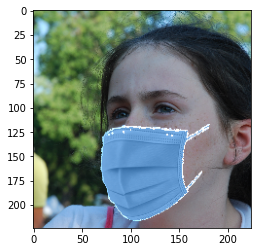

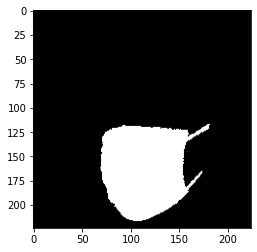

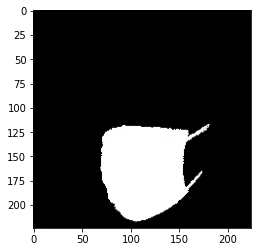

KeyboardInterrupt: 

In [375]:
train()

#### Data Augmentation

In [23]:
from torchvision.utils import save_image
root = "/Users/c.l.beothucus/Downloads/masked_dataset2/30000"
leaves = "/Users/c.l.beothucus/Downloads/binary_dataset2/30000/"
imgs_path =sorted(glob.glob(root+"/*.*"))
for path in imgs_path:   
    img = transform(Image.open(path))
    img = img.detach().cpu().view(-1,*(3,224,224))
    image_tensor = gen(img)
    image_tensor = (image_tensor + 1) / 2
    image_tensor = image_tensor.detach().cpu().view(-1, *(1,224,224))
    save_image(image_tensor,leaves+path[-14:])

## Morphological Image Processing

In [2]:
import numpy as np
import cv2
path = "/Users/c.l.beothucus/Downloads/binary_dataset2/23000"
pathh = "/Users/c.l.beothucus/Downloads/binary_dataset2(pros)/23000/"
kernel = np.ones((4,4),np.uint8)
imgs_path = sorted(glob.glob(path+"/*.*"))

for path in imgs_path:
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    ret, imgg = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(imgg, cv2.MORPH_OPEN, kernel)
    cv2.imwrite(pathh+path[-14:],opening)

In [3]:
import cv2
path = "/Users/c.l.beothucus/Desktop/anime/28250898_p0_master1200.jpg"
img = cv2.imread(path)#,cv2.IMREAD_GRAYSCALE)
print(img.shape)

(1000, 850, 3)


# Testing

In [7]:
path = "/Users/c.l.beothucus/Desktop/test2.jpg"
img = cv2.imread(path)
img = cv2.resize(img,(224,224))
cv2.imwrite("/Users/c.l.beothucus/Desktop/testing224.jpg",img)

True

In [62]:
from torchvision.utils import save_image
img_path = '/Users/c.l.beothucus/Downloads/test_imgs/dicky.jpg'
img = transform(Image.open(img_path))
img = img.detach().cpu().view(-1,*(img.shape))
pre = gen(img)
pre = (pre + 1) / 2
pre = pre.detach().cpu().view(-1, *(1,224,224))
save_image(pre,'/Users/c.l.beothucus/Downloads/test_imgs/white_dick.jpg')

In [8]:
import numpy as np
import cv2
binary_path = "/Users/c.l.beothucus/Desktop/bluwmask_binary.png"
kernel = np.ones((4,4),np.uint8)
img = cv2.imread(binary_path,cv2.IMREAD_GRAYSCALE)
ret, imgg = cv2.threshold(img,220,255,cv2.THRESH_BINARY)
opening = cv2.morphologyEx(imgg, cv2.MORPH_OPEN, kernel)
cv2.imwrite("/Users/c.l.beothucus/Desktop/blackwhite_test2.jpg",imgg)

True